In [1]:
import pandas as pd
import datetime as dt
import os
import re
import numpy as np
import tidytext
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import process
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import words

In [2]:
# read in the scored posts and make lower case
posts_df = pd.read_csv("scored_posts.csv")
posts_df.body = posts_df.body.str.lower()
posts_df.title = posts_df.title.str.lower()

# read in the tickers df and make lower case
tickers_df = pd.read_csv("tickers.csv")
tickers_df.ticker = tickers_df.ticker.str.lower()
tickers_df.name = tickers_df.name.str.lower()

In [3]:
posts_df.body.fillna("",inplace = True)

In [4]:
# first pull out all strings that start with $
found_dollars = []
for post in posts_df.body:
    captured_text = list(set(re.compile('(\$[a-z]+)').findall(post)))
    # make sure text in is ticker list
    matches = []
    for ticker in captured_text:
        clean_ticker = ticker.replace("$", "")
        if clean_ticker in list(tickers_df.ticker):
            matches.append(clean_ticker)
    found_dollars.append(', '.join(set(matches)))

# add list to main dataframe
posts_df["dollar_body_tickers"] = found_dollars
del found_dollars, matches, captured_text, clean_ticker

In [5]:
# first pull out all strings that start with $
found_dollars = []
for post in posts_df.title:
    captured_text = list(set(re.compile('(\$[a-z]+)').findall(post)))
    # make sure text in is ticker list
    matches = []
    for ticker in captured_text:
        clean_ticker = ticker.replace("$", "")
        if clean_ticker in list(tickers_df.ticker):
            matches.append(clean_ticker)
    found_dollars.append(', '.join(set(matches)))

# add list to main dataframe
posts_df["dollar_title_tickers"] = found_dollars
del found_dollars, matches, captured_text, clean_ticker

In [6]:
# need to parse out LLC etc; first figure out which are most frequent
# tokenize and count most frequent tokens in company names
names_tokens = [word_tokenize(name) for name in tickers_df.name]
flat_names_tokens = [item for sublist in names_tokens for item in sublist]
pd.Series(flat_names_tokens).value_counts()[0:50]
del flat_names_tokens

words_to_remove = [
'corp',
'inc.',
'inc',
'sa',
's.a.',
's.a',
'ltd',
'holdings',
'group',
'co',
'co.',
'trust',
'lp',
'motors',
'plc',
'international',
'partners',
'technologies',
'the',
'tech',
'(',
')',
'.',
'adr',
'holding',
'reit',
'holdings',
'holding',
'hldg',
'rh'
]

# remove the words
clean_names = []
for sentence in names_tokens:
    clean_word = [word for word in sentence if word not in words_to_remove]
    clean_names.append(' '.join(clean_word))

tickers_df['clean_names'] = clean_names
misleading_clean_names = ['best', 'ball', 'flex', 'points', 'post', 'pros', 'reading','align','aware','buckle','box','booking','popular','crown','city','now','escalade','exponent'
                         ,'franchise','freedom','guess','global','general','gap','hill','icon','hub','paper','integer','leaf','pool','quantum','construction','replay','repay'
                         ,'root','snap','shift','target','total','hilltop','gee','switch','team','interface','upstart','vector','universal','orange','usa','post']
tickers_df['clean_names'] = np.where(tickers_df.clean_names.isin(misleading_clean_names),tickers_df.name,tickers_df.clean_names)

clean_names = tickers_df.clean_names
# tickers_df.to_csv('clean_ticker_name.csv',index = False) 
# tickers_df.loc[tickers_df.clean_names.isin(words.words())].to_csv('englishword_name.csv')

In [7]:
# now we need to search for tickers and company names without dollar signs
# first tokenize the words (fyi this seperates out the $)
tokens = [word_tokenize(body) for body in posts_df.body]

# remove stopwords and punctuation
stop_words = set(stopwords.words('english'))

# remove the stop words and non-alpha from the tokens
clean_tokens = []
for sentence in tokens:
    filtered_sentence = []
    for word in sentence:
        if word not in stop_words and word.isalpha():
            filtered_sentence.append(word)
    clean_tokens.append(filtered_sentence)
    
# use all clean stock name as BOW, and check if the the list of token is in BOW and also remove if the matched name is actually english word
ticker_matches = []
for i in range(len(clean_tokens)):
    post_tickers = tickers_df.loc[~tickers_df.clean_names.isin(np.setdiff1d(clean_names,clean_tokens[i])),'ticker'].tolist()
    ticker_matches.append(', '.join(post_tickers))    
posts_df["namematch_body_tickers"] = ticker_matches

In [8]:
# now we need to search for tickers and company names without dollar signs
# first tokenize the words (fyi this seperates out the $)
tokens = [word_tokenize(body) for body in posts_df.title]

# remove stopwords and punctuation
stop_words = set(stopwords.words('english'))

# remove the stop words and non-alpha from the tokens
clean_tokens = []
for sentence in tokens:
    filtered_sentence = []
    for word in sentence:
        if word not in stop_words and word.isalpha():
            filtered_sentence.append(word)
    clean_tokens.append(filtered_sentence)

ticker_matches = []
for i in range(len(clean_tokens)):
    post_tickers = tickers_df.loc[~tickers_df.clean_names.isin(np.setdiff1d(clean_names,clean_tokens[i])),'ticker'].tolist()
    ticker_matches.append(', '.join(post_tickers))    
posts_df["namematch_title_tickers"] = ticker_matches

In [9]:
# find all the matching tickers per post that do not have a $ beforehand
# we need to retain the case here b/c they often put the ticker in uppercase
    # otherwise there are many incorrect matches
reg_case_posts_df = pd.read_csv("scored_posts.csv")
reg_case_posts_df.body.fillna("",inplace = True)
reg_case_tokens = [word_tokenize(body) for body in reg_case_posts_df.body]
reg_case_clean_tokens = []
for post in reg_case_tokens:
    filtered_post = []
    for word in post:
        if word.lower() not in stop_words and (word.isalpha()):
            filtered_post.append(word)
    reg_case_clean_tokens.append(filtered_post)
    
found_tickers = []
for i in range(len(reg_case_clean_tokens)):
    post_tickers = tickers_df.loc[~tickers_df.ticker.str.upper().isin(np.setdiff1d(tickers_df.ticker.str.upper().tolist(),reg_case_clean_tokens[i])),'ticker'].tolist()
    post_tickers = np.setdiff1d(post_tickers,["yolo", "edit", "stor", 'et', 'now', 'two','a','all','auto','tv','don','dd','on','be','new','ceo','go','are','b','cuz', 'man', 'roll',
                                              'rh','cars','true','love','rc','ipo','ever','coo','ta','si','td','itm','otm','e','big','see','free','stay','psa','x','huge',
                                              'good','real','ps','post'])
    found_tickers.append(', '.join(set(post_tickers)))
posts_df["tickermatch_body_tickers"]  = found_tickers

In [10]:
# find all the matching tickers per post that do not have a $ beforehand
# we need to retain the case here b/c they often put the ticker in uppercase
    # otherwise there are many incorrect matches
reg_case_tokens = [word_tokenize(body) for body in reg_case_posts_df.title]
reg_case_clean_tokens = []
for post in reg_case_tokens:
    filtered_post = []
    for word in post:
        if word.lower() not in stop_words and (word.isalpha()):
            filtered_post.append(word)
    reg_case_clean_tokens.append(filtered_post)
    
found_tickers = []
for i in range(len(reg_case_clean_tokens)):
    post_tickers = tickers_df.loc[~tickers_df.ticker.str.upper().isin(np.setdiff1d(tickers_df.ticker.str.upper().tolist(),reg_case_clean_tokens[i])),'ticker'].tolist()
    post_tickers = np.setdiff1d(post_tickers,["yolo", "edit", "stor", 'et', 'now', 'two','a','all','auto','tv','don','dd','on','be','new','ceo','go','are','b','cuz', 'man', 'roll',
                                              'rh','cars','true','love','rc','ipo','ever','coo','ta','si','td','itm','otm','e','big','see','free','stay','psa','x','huge',
                                              'good','real','ps','post'])
    found_tickers.append(', '.join(set(post_tickers)))
posts_df["tickermatch_title_tickers"]  = found_tickers

In [11]:
# add new columns with all found companies
posts_df["all_found_companies"] = posts_df.dollar_body_tickers + ", " + posts_df.dollar_title_tickers + ", " + posts_df.namematch_body_tickers + ", " + posts_df.namematch_title_tickers  + ", " + posts_df.tickermatch_title_tickers + ", " + posts_df.tickermatch_body_tickers 
posts_df['all_found_companies'] = posts_df['all_found_companies'].apply(lambda row: (
    re.sub(", ", " ", row).strip().upper()
))

# remove duplicates
posts_df['all_found_companies'] = posts_df['all_found_companies'].apply(lambda row: (
    ' '.join(set(row.split()))
))


# remove posts with no tickers and keep only important columns
final_df = posts_df[posts_df.all_found_companies != '']
final_df = final_df[["id", "url", "comms_num", "date", "sentiment_score", "all_found_companies"]]

In [12]:
posts_df[["id", "url", "comms_num", "date", "all_found_companies"]].to_csv('tagged_sentiment_posts_raw.csv',index = False)

In [13]:
final_df.to_csv('tagged_sentiment_posts.csv',index = False)

In [14]:
final_df_v2 = final_df[['date','sentiment_score','all_found_companies']]
final_df_v3 = pd.DataFrame(final_df_v2.all_found_companies.str.split(' ').tolist(), index=[final_df_v2.date,final_df_v2.sentiment_score]).stack().reset_index()[['date','sentiment_score',0]]
final_df_v3.columns = ['date','sentiment_score','company']
final_df_v3['sentiment'] = np.where(final_df_v3['sentiment_score']>0.05,'Bullish',np.where(final_df_v3['sentiment_score']<-0.05,'Bearish','Neutral'))
final_df_v3.date = pd.to_datetime(final_df_v3.date)
final_df_v3['date'] = final_df_v3['date'].apply(lambda x: x.date())
final_df_summary = final_df_v3.pivot_table(index = 'company',columns = 'sentiment',values = 'sentiment_score',aggfunc = 'count').fillna(0)
final_df_summary['Total_Post_Count']=final_df_summary.sum(axis = 1)

In [15]:
final_df_summary = final_df_summary.sort_values('Total_Post_Count',ascending = False)

In [16]:
final_df_summary.to_csv('analytics.csv')

In [17]:
# final_df_summary=final_df_summary.loc[~final_df_summary.index.isin(['GME','AMC'])]

In [18]:
final_df_summary = final_df_summary.sort_values('Total_Post_Count',ascending=False)

In [19]:
final_df_summary

sentiment,Bearish,Bullish,Neutral,Total_Post_Count
company,,,,
GME,56.0,117.0,49.0,222.0
AMC,17.0,55.0,14.0,86.0
UWMC,5.0,12.0,4.0,21.0
TSLA,4.0,11.0,3.0,18.0
PLTR,4.0,9.0,2.0,15.0
...,...,...,...,...
RNWK,1.0,0.0,0.0,1.0
RTX,0.0,1.0,0.0,1.0
ROG,0.0,0.0,1.0,1.0


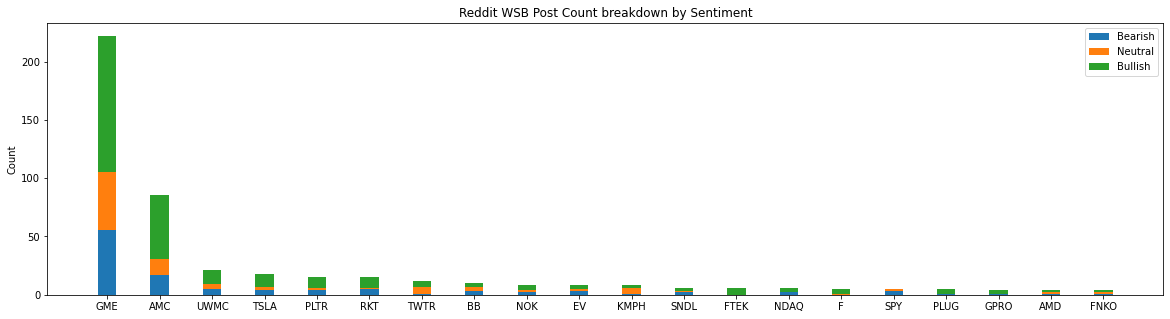

In [20]:

fig, ax = plt.subplots()
width = 0.35

labels = final_df_summary.index.tolist()[0:20]
bar1 = final_df_summary.Bearish[0:20]
bar2 = final_df_summary.Neutral[0:20]
bar3 = final_df_summary.Bullish[0:20]
bars = np.add(bar1, bar2).tolist()
 
   
ax.bar(labels, bar1, width, label='Bearish')
ax.bar(labels, bar2, bottom=bar1, width = width, label='Neutral')
ax.bar(labels, bar3, bottom=bars, width = width, label='Bullish')

ax.set_ylabel('Count')
ax.set_title('Reddit WSB Post Count breakdown by Sentiment')
ax.legend()
fig.set_size_inches(20,5)
plt.show()

In [21]:
# set range of dates to scrape 
import datetime as dt
start_day = dt.datetime(2021, 1, 25)
date_list = [start_day + dt.timedelta(days=x) for x in range(10)]

In [22]:
# read in the scored posts and make lower case
posts_df = pd.read_csv("scraped_posts.csv")

In [23]:
final_df_v3

,date,sentiment_score,company,sentiment
0,2021-03-17,0.805850,PFE,Bullish
1,2021-03-17,-0.999800,PLUG,Bearish
2,2021-03-17,0.310450,GME,Bullish
3,2021-03-17,0.999300,ATI,Bullish
4,2021-03-17,0.054000,VG,Bullish
...,...,...,...,...
773,2021-03-17,0.487200,AMC,Bullish
774,2021-03-17,0.487200,GME,Bullish
775,2021-03-17,0.009345,AMC,Neutral
776,2021-03-17,-0.164266,AMC,Bearish
